In [1]:
import os
import pandas as pd
import numpy as np
import random
from pprint import pprint

from tqdm.autonotebook import tqdm
import torch
from model import SimpleCLIP
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import transformers
from transformers import AutoFeatureExtractor, AutoTokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

/tmp/ipykernel_54451/3465970970.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
class CFG:
    file = './data/IQR_dev.tsv'   
    img_key = 'filepath'
    caption_key = 'title'
    max_text_len = 34
    text_ptm = "/home/yjw/ZYJ_WorkSpace/PTMs/chinese-roberta-wwm-ext-large/"
    img_ptm = "/home/yjw/ZYJ_WorkSpace/PTMs/vit-base-patch16-224/"
    save_path = "./checkpoints/finetuned-roberta-large-vit/best_checkpoint.pt"
    pretrained = True                 
    freeze = False
    dim = 2048
    device = 'cuda:0'
    batch_size = 128
    apex = True     

In [3]:
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer):
        self.tokenizer = tokenizer
        self.texts = texts
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        text_tensor = self.tokenizer(text, 
                                max_length=CFG.max_text_len, 
                                truncation=True, 
                                return_tensors='pt', 
                                padding="max_length",)
        for k,v in text_tensor.items():
            text_tensor[k] = v.squeeze()
        return text_tensor
        
class ImgDataset(Dataset):
    def __init__(self, img_paths, feature_extractor):
        self.feature_extractor = feature_extractor
        self.img_paths = img_paths
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, item):
        img_path = self.img_paths[item]
        img_tensor = self.feature_extractor(Image.open(img_path).convert("RGB"), return_tensors="pt")
        for k,v in img_tensor.items():
            img_tensor[k] = v.squeeze()
        return img_tensor

In [4]:
class Engine:
    def __init__(self):
        self.device = torch.device(CFG.device)
        self.clipModel = SimpleCLIP(CFG.dim, CFG.text_ptm, CFG.img_ptm, self.device, pretrained=CFG.pretrained,freeze=CFG.freeze)
        self.clipModel.load_state_dict(torch.load(CFG.save_path))
        self.clipModel.eval()
        self.clipModel = self.clipModel.to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(CFG.text_ptm)
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(CFG.img_ptm)
    def encode_text(self, text_or_texts):
        if type(text_or_texts) == str:
            text = text_or_texts
            inputs = self.tokenizer(text, 
                                max_length=CFG.max_text_len, 
                                truncation=True, 
                                return_tensors='pt', 
                                padding="max_length",)
            for k,v in inputs.items():
                inputs[k] = v.to(self.device)
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=CFG.apex):
                    feat = self.clipModel.textencoder(inputs)
                feat = feat @ self.clipModel.text_projection
        else:
            dataset = TextDataset(text_or_texts, self.tokenizer)
            dataloader = DataLoader(dataset, batch_size=CFG.batch_size, shuffle=False)
            feat = []
            for batch in tqdm(dataloader, total=len(dataloader), desc="Text encode"):
                for k,v in batch.items():
                    batch[k] = v.to(self.device)
                with torch.no_grad():
                    with torch.cuda.amp.autocast(enabled=CFG.apex):
                        batch_feat = self.clipModel.textencoder(batch)
                    batch_feat = batch_feat @ self.clipModel.text_projection
                feat.append(batch_feat)
            feat = torch.cat(feat)
        return feat.squeeze().cpu()
    def encode_img(self, img_or_imgs):
        if type(img_or_imgs) == str:
            img_path = img_or_imgs
            img_tensor = self.feature_extractor(Image.open(img_path).convert("RGB"), return_tensors="pt")
            for k,v in img_tensor.items():
                img_tensor[k] = v.to(self.device)
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=CFG.apex):
                    feat = self.clipModel.imgencoder(img_tensor)
                feat = feat @ self.clipModel.img_projection
        else:
            dataset = ImgDataset(img_or_imgs, self.feature_extractor)
            dataloader = DataLoader(dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=5)
            feat = []
            for batch in tqdm(dataloader, total=len(dataloader), desc="Img encode"):
                for k,v in batch.items():
                    batch[k] = v.to(self.device)
                with torch.no_grad():
                    with torch.cuda.amp.autocast(enabled=CFG.apex):
                        batch_feat = self.clipModel.imgencoder(batch)
                    batch_feat = batch_feat @ self.clipModel.img_projection
                feat.append(batch_feat)
            feat = torch.cat(feat)
        return feat.squeeze().cpu()
engine = Engine()            

Some weights of the model checkpoint at /home/yjw/ZYJ_WorkSpace/PTMs/chinese-roberta-wwm-ext-large/ were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
df = pd.read_csv(CFG.file, sep="\t")
texts = df[CFG.caption_key].values
img_paths = df[CFG.img_key].values
text_feats = engine.encode_text(texts)
img_feats = engine.encode_img(img_paths)
torch.cuda.empty_cache()
text_feats.shape, img_feats.shape

Text encode:   0%|          | 0/157 [00:00<?, ?it/s]

Img encode:   0%|          | 0/157 [00:00<?, ?it/s]

/home/yjw/miniconda3/envs/VLP/lib/python3.8/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/yjw/miniconda3/envs/VLP/lib/python3.8/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/yjw/miniconda3/envs/VLP/lib/python3.8/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(torch.Size([19997, 2048]), torch.Size([19997, 2048]))

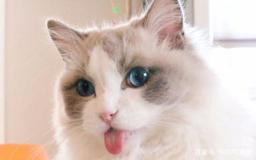

title=布偶猫卖萌	score=0.8026015758514404


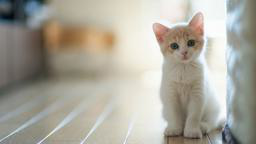

title=喵星人电脑壁纸可爱小清新	score=0.8002684116363525


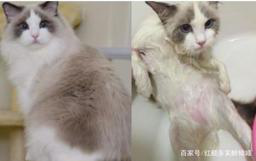

title=布偶猫满月	score=0.7899482846260071


In [16]:
query = "白色的小猫"
values, indices = torch.topk(img_feats @ engine.encode_text(query).t(), 3)
for i in range(len(values)):
    Image.open(img_paths[indices[i]]).show()
    print(f"title={texts[indices[i]]}\tscore={values[i]}")